# Testing Cloud Shadow Geometry

In this notebook we test several iterations of cloud shadow geometry based on existing cloud labels.

## Import packages

In [43]:
import os
import cv2
import warnings
import math
import numpy as np
import rioxarray as rio
import xml.etree.ElementTree as ET

## Define Filenames

In [44]:
data_dir = '/Users/jacaraba/Desktop/development/ilab/vhr-cloudmask/data/shadow'
data_filename = os.path.join(data_dir, 'WV02_20101020_M1BS_1030010007BBFA00-toa_subset_data.tif')
cloud_filename = os.path.join(data_dir, 'WV02_20101020_M1BS_1030010007BBFA00-toa_subset_label.tif')
metadata_filename = os.path.join(data_dir, 'WV02_20101020_M1BS_1030010007BBFA00-toa.xml')

In [45]:
#data_dir = '/Users/jacaraba/Desktop/development/ilab/vhr-cloudmask/data/shadow'
#data_filename = os.path.join(data_dir, 'WV02_20101020_M1BS_1030010007BBFA00-toa_subset_data_v2.tif')
#cloud_filename = os.path.join(data_dir, 'WV02_20101020_M1BS_1030010007BBFA00-toa_subset_label_v2.tif')
#metadata_filename = os.path.join(data_dir, 'WV02_20101020_M1BS_1030010007BBFA00-toa.xml')

## Open Imagery

In [46]:
data = rio.open_rasterio(data_filename).values
cloud = np.squeeze(rio.open_rasterio(cloud_filename).values)
cloud.shape

(936, 1018)

## Open XML and grab XML metadata

In [47]:
def get_xml_tag(imd_tag, xml_tag):
    value = imd_tag.find('IMAGE').find(xml_tag)
    if value is not None:
        return float(value.text)
    else:
        warnings.warn('Unable to locate {}, return None.'.format(xml_tag))
        return None

In [48]:
tree = ET.parse(metadata_filename)
imd_tag = tree.getroot().find('IMD')

band_list = [n.tag for n in imd_tag if n.tag.startswith('BAND_')]

mean_sunaz = get_xml_tag(imd_tag, 'MEANSUNAZ')
mean_sunel = get_xml_tag(imd_tag, 'MEANSUNEL')
mean_sunzen = 90.0 - mean_sunel

mean_sataz = get_xml_tag(imd_tag, 'MEANSATAZ')
mean_satel = get_xml_tag(imd_tag, 'MEANSATEL')
mean_satzen = 90.0 - mean_satel

mean_intrack_viewangle = get_xml_tag(imd_tag, 'MEANINTRACKVIEWANGLE')
mean_crosstrack_viewangle = get_xml_tag(imd_tag, 'MEANCROSSTRACKVIEWANGLE')
mean_offnadir_viewangle = get_xml_tag(imd_tag, 'MEANOFFNADIRVIEWANGLE')

## Get Polygons

In [49]:
import rasterio.features
from shapely.geometry import shape

# Mask is a numpy array binary mask loaded however needed
maskShape = rasterio.features.shapes(cloud.astype('uint8'))
mypoly=[]
for vec in maskShape:
    mypoly.append(vec[0])

from shapely.geometry import Polygon, shape
import matplotlib.pyplot as plt
import geopandas as gpd


from shapely.geometry import shape
geom = [shape(i) for i in mypoly]
geometry = gpd.GeoDataFrame({'geometry':geom})
centroids = geometry.centroid
print(centroids.iloc[0].x, centroids.iloc[0].y)

# plot contour found
# polygon1 = geometry.iloc[0]
# print(polygon1)
# p = gpd.GeoSeries(polygon1)
# p.plot()
# plt.show()

575.4080824088747 260.7715266772319


## Get Direction of the Cloud

Some equations listed here.

brightness = (red+green+blue+nir)/4, lower brightness, more probability of cloud, clustering to get darkest clusters in the area, fuzzy kmeans could work

Determination of Orthographic Positions of Clouds and Their Shadows

Cloud orthographic position is very critical for characterizing solar-cloud-sensor geometry and together with cloud top height, it is an indispensable variable in determining the scope of cloud shadow. Theoretically, it is straightforward to determine the cloud actual position if providing cloud height, zenith and azimuth angles of both solar and satellite as well as the cloud projection on the remotely sensed image. In this study, the needed angles and cloud height are derived from MOD03 and MOD06 products. Orthographic positions of the cloud and associated shadow are determined using the following formula. An alternative effective shadow detection approach can be referred to [8].

Xcld = xmap + H tan θv sin φv  
Ycld = ymap + H tan θv cos φv  

Xshw = Xcld − H tan θs sin φs  
Yshw = Ycld − H tan θs cos φs  

where (Xshw, Yshw) is the orthographic position of cloud shadow on the surface; (Xcld, Ycld) is cloud vertical projection on the surface; (xmap, ymap) is cloud projection in the remotely sensed image which is probably a pseudo position; H is cloud top height above the surface, in this study it is the difference between the cloud top height from MOD06 minus the surface elevation from MOD03; θv and φv are the observing zenith and azimuth angles, respectively; and θs and φs are the solar zenith and azimuth angles, respectively. Note that, in Equations (1) and (2), the azimuth angle is in the range of [−180°, 180°], the true north is at 0-degree azimuth, east has an azimuth of 90°, and west has an azimuth of −90°.

Here we then need:

1. centroid of the cloud for xmap and ymap 
2. θv and φv are the observing zenith and azimuth angles
3. θs and φs are the solar zenith and azimuth angles

In [50]:
xmap = centroids.iloc[2].x
ymap = centroids.iloc[2].y

print(f"θs   = {mean_sunzen}")
print(f"φs   = {mean_sunaz}")
print(f"θv   = {mean_satzen}")
print(f"φv   = {mean_sataz}")
print(f"xmap = {centroids.iloc[0].x}")
print(f"ymap = {centroids.iloc[0].y}")

θs   = 28.35
φs   = 148.35
θv   = 12.200000000000003
φv   = 140.9
xmap = 575.4080824088747
ymap = 260.7715266772319


the WMO also classified clouds by altitude and divided the troposphere into 3 levels: 
Low-level Clouds: < 6,500 ft.
Mid-level Clouds: 6,500 to 23,000 ft.
High-level Clouds: 16,500 to 45,000 ft.


In [51]:
x = []
y = []

for H in [200, 400, 12000]:

    Xcld = xmap + H * math.tan(mean_satzen) * math.sin(mean_sataz)
    Ycld = ymap + H * math.tan(mean_satzen) * math.cos(mean_sataz)
    print(f"Xcld   = {Xcld}")
    print(f"Ycld   = {Ycld}")

    Xshw = Xcld + H * math.tan(mean_sunzen) * math.sin(mean_sunaz)
    Yshw = Ycld + H * math.tan(mean_sunzen) * math.cos(mean_sunaz)
    print(f"Xshw   = {Xshw}")
    print(f"Yshw   = {Yshw}")

    x.append(Xshw)
    y.append(Yshw)

Xcld   = 478.3404697597013
Ycld   = 592.9217676408992
Xshw   = 468.62914453849214
Yshw   = 581.2778169112682
Xcld   = 443.47238416458754
Ycld   = 661.2814683666202
Xshw   = 424.0497337221692
Yshw   = 637.9935669073582
Xcld   = -1578.8765803520114
Ycld   = 4626.144110458433
Xshw   = -2161.556093624561
Yshw   = 3927.5070666805714


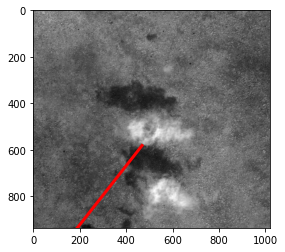

In [52]:
plt.plot(x, y, color="red", linewidth=3)
plt.imshow(data[5, :, :])
plt.show()

# Test Some Indices for Shadow and Cloud Detection

In [53]:
band_list

['BAND_C',
 'BAND_B',
 'BAND_G',
 'BAND_Y',
 'BAND_R',
 'BAND_RE',
 'BAND_N',
 'BAND_N2']

In [54]:
NIR1 = band_list.index('BAND_N')
BLUE = band_list.index('BAND_B')
GREEN = band_list.index('BAND_G')
RED = band_list.index('BAND_R')

In [55]:
ci_1 = (3 * data[NIR1, :, :]) / (data[RED, :, :] + data[GREEN, :, :] + data[BLUE, :, :] + 1)
ci_2 = (data[RED, :, :] + data[GREEN, :, :] + data[BLUE, :, :] + data[NIR1, :, :]) / 4
ci_1.shape

(936, 1018)

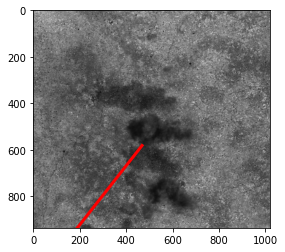

In [56]:
plt.plot(x, y, color="red", linewidth=3)
plt.imshow(ci_1)
plt.show()

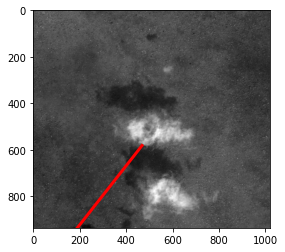

In [57]:
plt.plot(x, y, color="red", linewidth=3)
plt.imshow(ci_2)
plt.show()

In [58]:
# t2 = 1/10, 1/9, 1/8, 1/7, 1/6, 1/5, 1/4, 1/3,1/2}
t2 = 1/10
T1 = 1
T7 = 25
T2 = np.mean(ci_2) + (t2 * (np.max(ci_2) - np.mean(ci_2)))

prelim_cloud_mask = np.float32(np.logical_and(np.abs(ci_1 - 1) < T1, ci_2 > T2))
final_cloud_mask = prelim_cloud_mask  #cv2.medianBlur(prelim_cloud_mask, T7)
# final_cloud_mask = np.expand_dims(final_cloud_mask, axis = 2).astype(np.uint8)

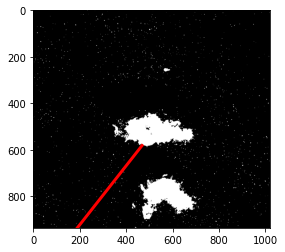

In [59]:
plt.plot(x, y, color="red", linewidth=3)
plt.imshow(final_cloud_mask)
plt.show()

In [60]:
t3 = 1/4
t4 = 1/2
T5 = 400
T6 = 400

T3 = np.min(data[NIR1, :, :]) + (t3 * (np.mean(data[NIR1, :, :]) - np.min(data[NIR1:, :])))
T4 = np.min(data[BLUE, :, :]) + (t4 * (np.mean(data[BLUE, :, :]) - np.min(data[BLUE, :, :])))

prelim_cloud_shadow_mask = np.float32(np.logical_and(data[NIR1, :, :] < T3, data[BLUE, :, :] < T4))

spatial_search_kernel = np.ones((T5, T6), dtype = np.float32)
non_pseudo_cloud_shadow_position_mask = cv2.filter2D(final_cloud_mask, -1, spatial_search_kernel) < 0

refined_cloud_shadow_mask = prelim_cloud_shadow_mask * non_pseudo_cloud_shadow_position_mask
final_cloud_shadow_mask = refined_cloud_shadow_mask #cv2.medianBlur(refined_cloud_shadow_mask, T8)
final_cloud_shadow_mask = np.expand_dims(final_cloud_shadow_mask, axis = 2).astype(np.uint8)


#metadata['count'] = 1
#metadata['dtype'] = 'uint8'

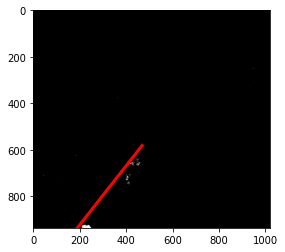

In [61]:
plt.plot(x, y, color="red", linewidth=3)
plt.imshow(prelim_cloud_shadow_mask)
plt.show()

In [62]:
# SDI = ((NIR2-Blue)/(NIR2+Blue)) - NIR1
NIR1 = band_list.index('BAND_N')
NIR2 = band_list.index('BAND_N2')
BLUE = band_list.index('BAND_B')
GREEN = band_list.index('BAND_G')
RED = band_list.index('BAND_R')

SDI = ((data[NIR2, :, :] - data[BLUE, :, :])/(data[NIR2, :, :] + data[BLUE, :, :])) - data[NIR1, :, :]
print(SDI.min(), SDI.max(), SDI.mean())

-4325.573394495413 -1612.0267857142858 -2887.741607135029


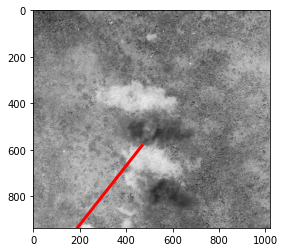

In [63]:
plt.plot(x, y, color="red", linewidth=3)
plt.imshow(SDI)
plt.show()

/var/folders/0d/39wrbn0x5cj0tnx9n5yx6f440000gp/T/ipykernel_4858/915329163.py:2: RuntimeWarning: invalid value encountered in power
  SI = (data[BLUE, :, :] * data[GREEN, :, :] * data[RED, :, :]) ** (1.0 / 3)


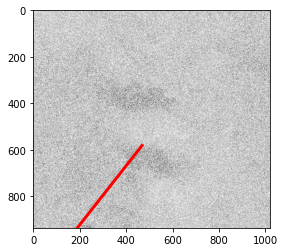

In [64]:
# Shadow Index (SI), SI := (Blue * Green * Red) ** (1.0 / 3)
SI = (data[BLUE, :, :] * data[GREEN, :, :] * data[RED, :, :]) ** (1.0 / 3)
SI[np.isnan(SI)] = 0
plt.plot(x, y, color="red", linewidth=3)
plt.imshow(2*SI/SDI)
plt.show()

https://www.sciencedirect.com/science/article/pii/S0273117718302138

ratio_b_nir = tan-1((B - NIR) / (B + NIR))
c3 = tan -1 (b / max(R, G))
c3_new = tan-1(B/PAN)
c4_water = tan-1(NIR/PAN)

In [65]:
ratio_b_nir = np.arctan(((data[BLUE, :, :] - data[NIR1, :, :]) / (data[BLUE, :, :] + data[NIR1, :, :])))
c3 = np.arctan((data[BLUE, :, :] / max(np.max(data[RED, :, :]), np.max(data[GREEN, :, :]))))

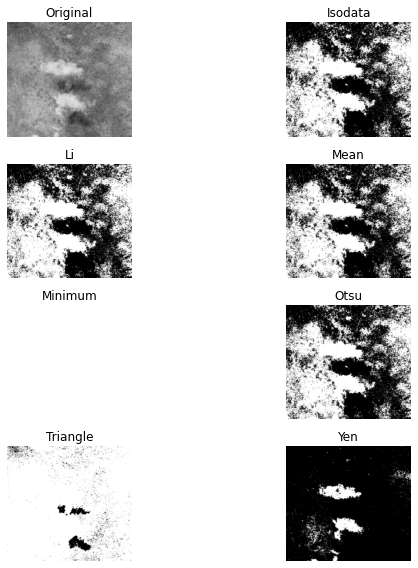

In [66]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(SDI, figsize=(10, 8), verbose=False)
plt.show()

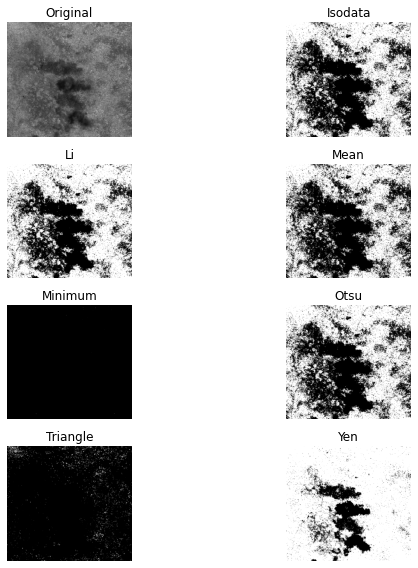

In [67]:
fig, ax = try_all_threshold(ci_1, figsize=(10, 8), verbose=False)
plt.show()

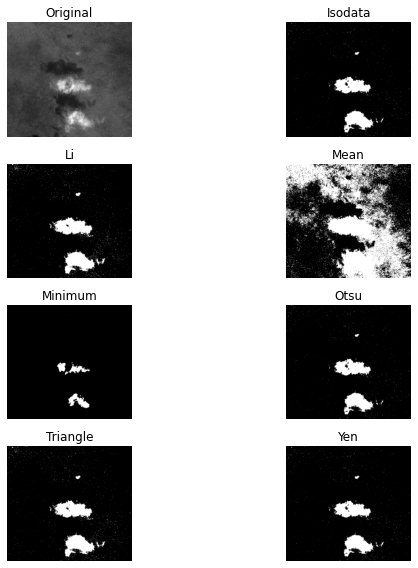

In [68]:
fig, ax = try_all_threshold(ci_2, figsize=(10, 8), verbose=False)
plt.show()

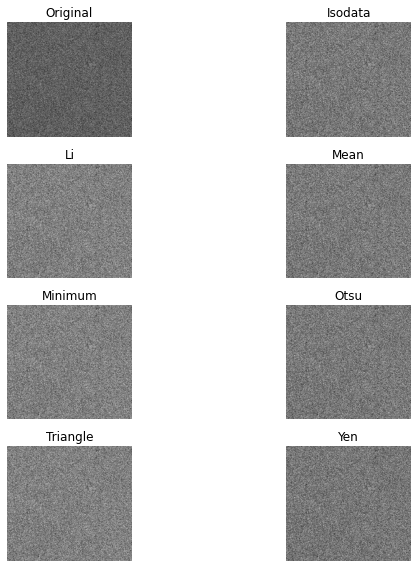

In [69]:
fig, ax = try_all_threshold(SI, figsize=(10, 8), verbose=False)
plt.show()

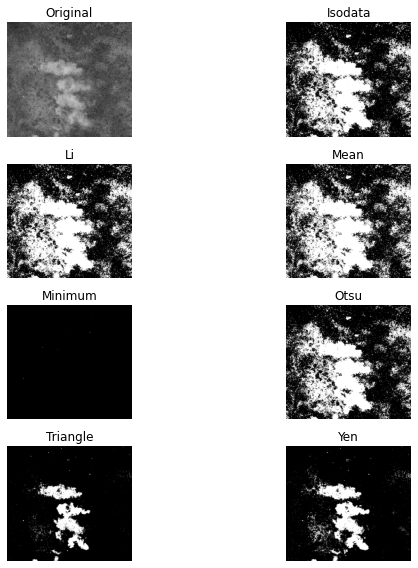

In [70]:
fig, ax = try_all_threshold(ratio_b_nir, figsize=(10, 8), verbose=False)
plt.show()

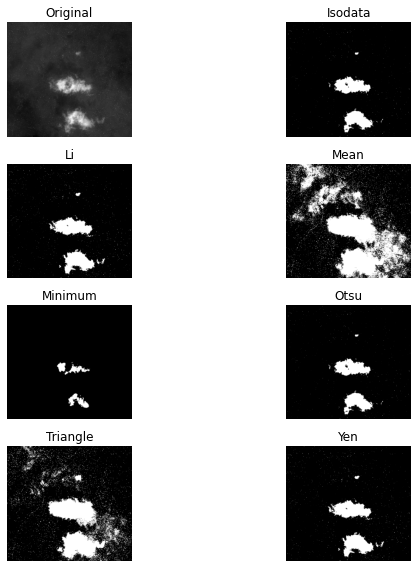

In [71]:
fig, ax = try_all_threshold(c3, figsize=(10, 8), verbose=False)
plt.show()

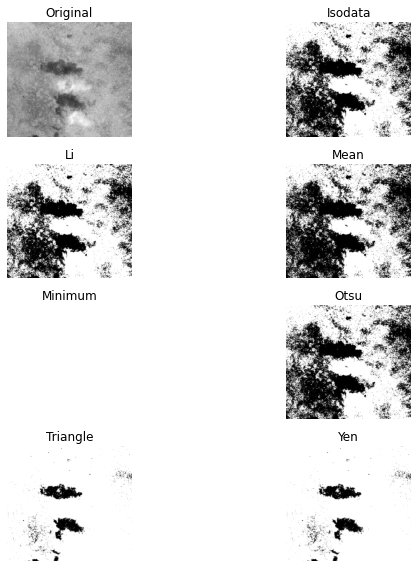

In [72]:
ccfe = c3 - ratio_b_nir
fig, ax = try_all_threshold(ccfe, figsize=(10, 8), verbose=False)
plt.show()

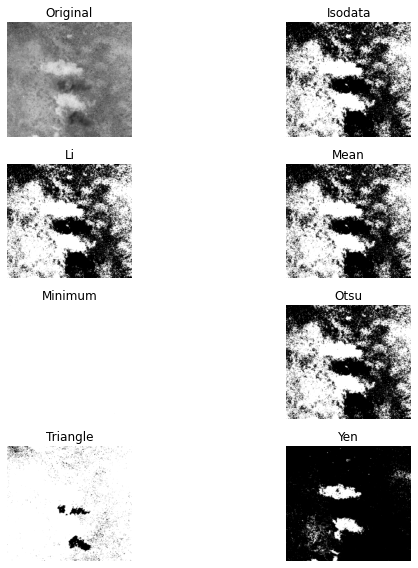

In [73]:
cc54 = c3 - ratio_b_nir + SDI
fig, ax = try_all_threshold(cc54, figsize=(10, 8), verbose=False)
plt.show()

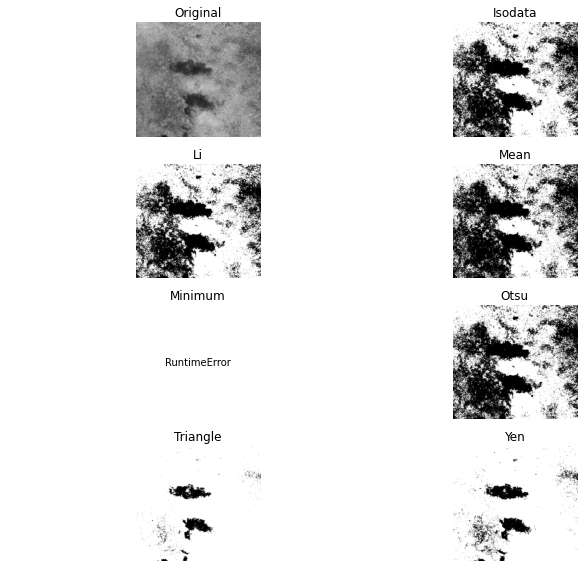

In [74]:
cc23 = (c3 - ratio_b_nir) / SDI
fig, ax = try_all_threshold(cc23, figsize=(10, 8), verbose=False)
plt.show()

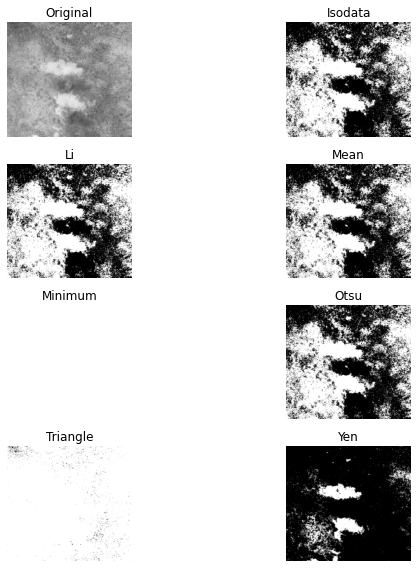

In [75]:
cc22 =  SDI / (c3 - ratio_b_nir) 
fig, ax = try_all_threshold(cc22, figsize=(10, 8), verbose=False)
plt.show()

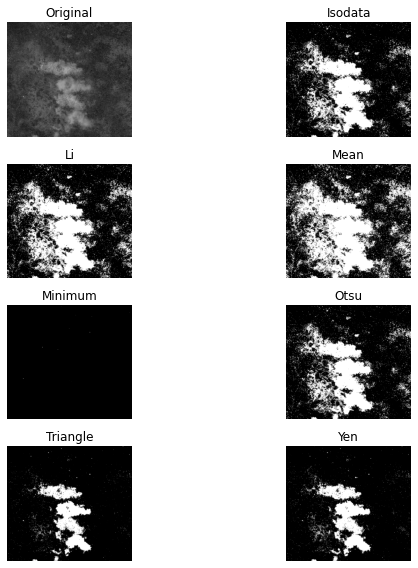

In [76]:
ccx =  np.arctan((SDI - c3 - ratio_b_nir)/(SDI + c3 + ratio_b_nir))
fig, ax = try_all_threshold(ccx, figsize=(10, 8), verbose=False)
plt.show()

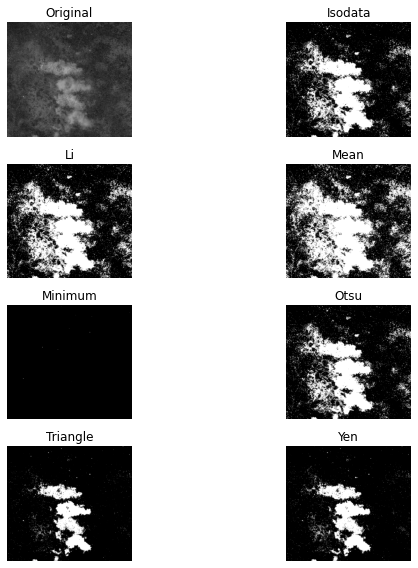

In [77]:
ccz =  (SDI - c3 - ratio_b_nir)/(SDI + c3 + ratio_b_nir)
fig, ax = try_all_threshold(ccz, figsize=(10, 8), verbose=False)
plt.show()

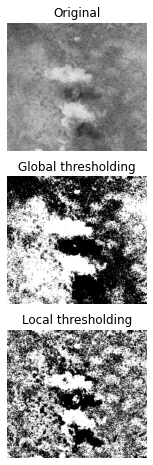

In [78]:
from skimage.filters import threshold_otsu, threshold_local

image = cc54
global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 255
local_thresh = threshold_local(image, block_size, offset=10)
binary_local = image > local_thresh

fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax = axes.ravel()
plt.gray()

ax[0].imshow(image)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_local)
ax[2].set_title('Local thresholding')

for a in ax:
    a.axis('off')

plt.show()

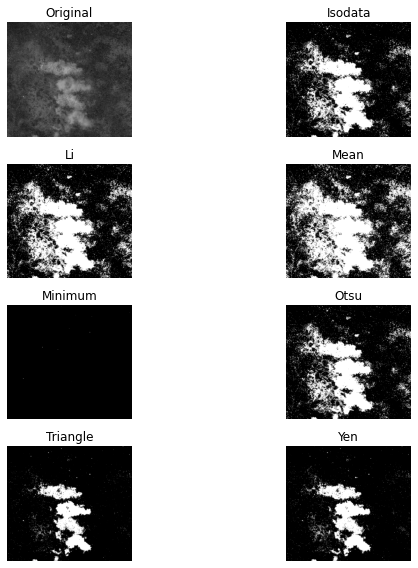

In [79]:
import skimage

# convert the image to grayscale
#gray_image = skimage.color.rgb2gray(image)

# blur the image to denoise
blurred_image = skimage.filters.gaussian(cc54, sigma=1.0)

fig, ax = try_all_threshold(ccz, figsize=(10, 8), verbose=False)
plt.show()

[0 1]


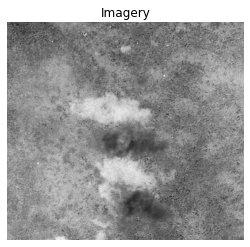

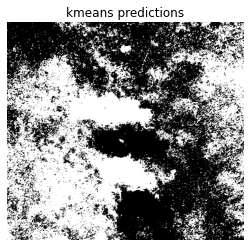

In [80]:
from sklearn.cluster import KMeans
import xarray as xr
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt


# grab the number of bands in the image, naip images have four bands
img = np.expand_dims(cc54, 0)
nbands = img.shape[0]

# create an empty array in which each column will hold a flattened band
flat_data = np.empty((img.shape[1]*img.shape[2], nbands))

# loop through each band in the image and add to the data array
for i in range(nbands):
    band = img[i, :, :]
    flat_data[:, i-1] = band.flatten()

# set up the kmeans classification by specifying the number of clusters 
km = KMeans(n_clusters=2)
# begin iteratively computing the position of the two clusters
km.fit(flat_data)

# use the sklearn kmeans .predict method to assign all the pixels of an image to a unique cluster
flat_predictions = km.predict(flat_data)

# rehsape the flattened precition array into an MxN prediction mask
prediction_mask = flat_predictions.reshape((img.shape[1], img.shape[2]))
print(np.unique(prediction_mask))

#plot the imagery and the prediction mask for comparison

plt.imshow(img[0,:,:])
plt.title("Imagery")
plt.axis('off')
#plt.close()
plt.show()

plt.imshow(prediction_mask)
plt.title('kmeans predictions')
plt.axis('off')
#plt.close()
plt.show()